# Quick start

> Optimizing data sampling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from trufl.utils import gridder
from trufl.sampler import Sampler


%load_ext autoreload
%autoreload 2

## Create a vector grid from a given raster

In [2]:
fname_raster = '../files/ground-truth-02-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

<Axes: >

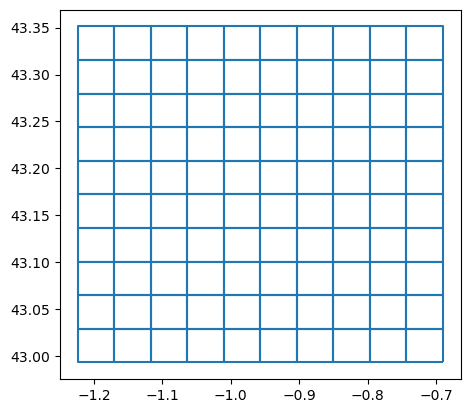

In [3]:
gdf_grid.boundary.plot()

## Emulating data collection

### Random sample

Generating a random set of points within a given polygon geoseries.

<Axes: >

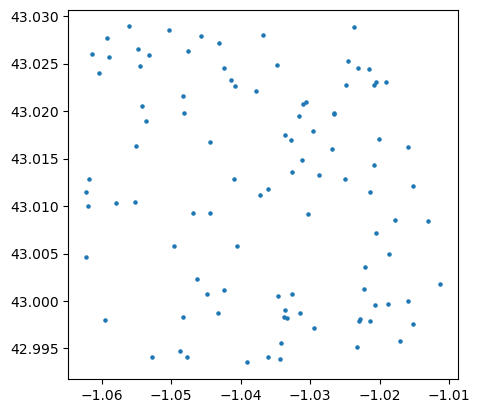

In [13]:
loc_id = 30
n_pts = 100
sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n_pts)
sampling_locs.plot(markersize=5)

### Emulate data collection

Sample simulated values/measurements from a given `.tiff` raster file at given locations.

In [14]:
sampler = Sampler(fname_raster)
gdf_samples = sampler.sample(sampling_locs)

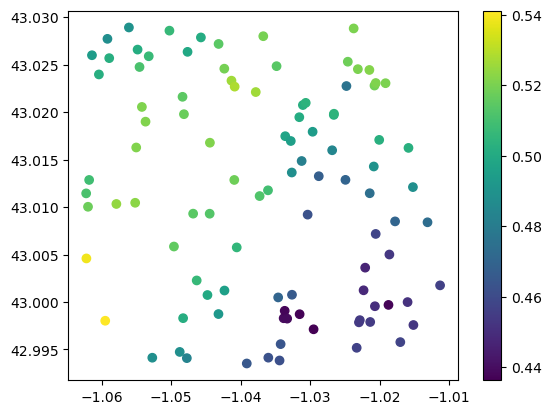

In [15]:
gdf_samples.plot(column='value', legend=True);